In [200]:
import numpy as np
import pandas as pd

from datetime import date,datetime
from dateutil.relativedelta import relativedelta as rd

import os
from functools import reduce

from sklearn.linear_model import PassiveAggressiveClassifier,Perceptron
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from scikitplot.metrics import plot_roc_curve

## Lectura de datos

In [10]:
ruta = '/home/jose/Documentos/bd/chicago/'
l_arch = [os.path.join(ruta,a) for a in os.listdir(ruta) if a.endswith('.csv')]
l_arch.sort()
l_arch

['/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_01.csv',
 '/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_02.csv',
 '/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_03.csv',
 '/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_04.csv',
 '/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_05.csv',
 '/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_06.csv',
 '/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_07.csv',
 '/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_08.csv',
 '/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_09.csv',
 '/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_10.csv',
 '/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_11.csv',
 '/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_12.csv']

In [11]:
df = pd.concat(map(lambda a:pd.read_csv(a),l_arch),ignore_index=True)
df = df[['taxi_id','trip_start_timestamp','trip_seconds','trip_miles','tips','trip_total']].copy()
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp']).dt.date
df['fh'] = df['trip_start_timestamp'].map(lambda x:x.month)
df.drop('trip_start_timestamp',axis=1,inplace=True)

In [29]:
df.head()

,taxi_id,trip_seconds,trip_miles,tips,trip_total,fh
0,85.0,180.0,0.40,0.00,4.50,1
1,2776.0,240.0,0.70,4.45,8.90,1
2,3168.0,0.0,0.00,5.00,47.75,1
3,4237.0,480.0,1.10,0.00,7.00,1
4,5710.0,480.0,2.71,0.00,10.25,1


In [39]:
df['n'] = 1

## Ingeniería de datos

### Espacio de predictoras $\mathcal{X}$

In [31]:
id_='taxi_id'

In [30]:
vobs = 3
vdes = 1
fhi,fhf = (1,12)
anclai = fhi+vobs-1
anclaf = fhf-vdes
anclai,anclaf

(3, 11)

In [52]:
def trans(df,v,k,ancla):
    aux = df[[id_,v,'fh']].copy()
    aux = aux.loc[(aux['fh']>=(ancla-k+1))&((aux['fh']<=ancla))].reset_index(drop=True).drop('fh',axis=1)
    aux = aux.groupby(id_).agg(['mean','sum'])
    aux.columns = ["v_%s_%d_"%(v,k)+"_".join(x) for x in aux.columns]
    return aux.reset_index().assign(ancla=ancla)

In [54]:
um = [id_,'ancla']

In [58]:
X = pd.concat(map(lambda ancla:reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'),
                           map(lambda var: trans(df,var,3,ancla),
                               ['trip_seconds','trip_miles','tips','trip_total','n'])),range(anclai,anclaf+1)),
              ignore_index=True)

In [59]:
X.head()

,taxi_id,v_trip_seconds_3_trip_seconds_mean,v_trip_seconds_3_trip_seconds_sum,ancla,v_trip_miles_3_trip_miles_mean,v_trip_miles_3_trip_miles_sum,v_tips_3_tips_mean,v_tips_3_tips_sum,v_trip_total_3_trip_total_mean,v_trip_total_3_trip_total_sum,v_n_3_n_mean,v_n_3_n_sum
0,0.0,741.291946,883620.0,3,4.210403,5018.8,1.669874,1990.49,16.470470,19632.80,1,1192
1,3.0,684.223602,110160.0,3,0.185714,29.9,1.843851,296.86,15.831739,2548.91,1,161
2,4.0,631.743772,1065120.0,3,2.878351,4852.9,1.224680,2064.81,12.569698,21192.51,1,1686
3,5.0,1067.194030,715020.0,3,5.715522,3829.4,1.985672,1330.40,37.203612,24926.42,1,670
4,6.0,666.156275,844020.0,3,0.000000,0.0,1.390908,1762.28,14.088129,17849.66,1,1267


### Target (variable objetivo $\vec{y}$)

In [75]:
def target(df,ancla):
    aux = df[[id_,'fh']].copy()
    aux = aux.loc[aux['fh']==(ancla+vdes)].reset_index(drop=True).drop('fh',axis=1).assign(ancla=ancla)
    return aux.drop_duplicates().reset_index(drop=True)

In [76]:
y = pd.concat(map(lambda ancla: target(df,ancla),range(anclai,anclaf+1)),ignore_index=True)

In [77]:
y.shape

(47610, 2)

### Construcción de TAD (Tabla Analítica de datos $\vec{y}=f(\mathcal{X})$

In [80]:
tad = X.merge(y,on=um,how='left',indicator=True)

In [84]:
tad['y'] = (tad._merge == 'left_only').astype(int)

In [85]:
tad.drop('_merge',axis=1,inplace=True)

In [86]:
tad.head()

,taxi_id,v_trip_seconds_3_trip_seconds_mean,v_trip_seconds_3_trip_seconds_sum,ancla,v_trip_miles_3_trip_miles_mean,v_trip_miles_3_trip_miles_sum,v_tips_3_tips_mean,v_tips_3_tips_sum,v_trip_total_3_trip_total_mean,v_trip_total_3_trip_total_sum,v_n_3_n_mean,v_n_3_n_sum,y
0,0.0,741.291946,883620.0,3,4.210403,5018.8,1.669874,1990.49,16.470470,19632.80,1,1192,0
1,3.0,684.223602,110160.0,3,0.185714,29.9,1.843851,296.86,15.831739,2548.91,1,161,1
2,4.0,631.743772,1065120.0,3,2.878351,4852.9,1.224680,2064.81,12.569698,21192.51,1,1686,0
3,5.0,1067.194030,715020.0,3,5.715522,3829.4,1.985672,1330.40,37.203612,24926.42,1,670,0
4,6.0,666.156275,844020.0,3,0.000000,0.0,1.390908,1762.28,14.088129,17849.66,1,1267,0


## Análisis Exploratorio de Datos

In [88]:
varc = [v for v in tad.columns if v[:2]=='v_']
tgt = 'y'

### Missings

In [94]:
miss = 1- tad[varc].describe().T[['count']]/len(tad)
miss

,count
v_trip_seconds_3_trip_seconds_mean,0.0
v_trip_seconds_3_trip_seconds_sum,0.0
v_trip_miles_3_trip_miles_mean,0.0
v_trip_miles_3_trip_miles_sum,0.0
v_tips_3_tips_mean,0.0
v_tips_3_tips_sum,0.0
v_trip_total_3_trip_total_mean,0.0
v_trip_total_3_trip_total_sum,0.0
v_n_3_n_mean,0.0
v_n_3_n_sum,0.0


In [95]:
tad.shape,tad.dropna().shape

((56611, 13), (56611, 13))

In [92]:
tad = tad.dropna().reset_index(drop=True)

In [96]:
tad.head()

,taxi_id,v_trip_seconds_3_trip_seconds_mean,v_trip_seconds_3_trip_seconds_sum,ancla,v_trip_miles_3_trip_miles_mean,v_trip_miles_3_trip_miles_sum,v_tips_3_tips_mean,v_tips_3_tips_sum,v_trip_total_3_trip_total_mean,v_trip_total_3_trip_total_sum,v_n_3_n_mean,v_n_3_n_sum,y
0,0.0,741.291946,883620.0,3,4.210403,5018.8,1.669874,1990.49,16.470470,19632.80,1,1192,0
1,3.0,684.223602,110160.0,3,0.185714,29.9,1.843851,296.86,15.831739,2548.91,1,161,1
2,4.0,631.743772,1065120.0,3,2.878351,4852.9,1.224680,2064.81,12.569698,21192.51,1,1686,0
3,5.0,1067.194030,715020.0,3,5.715522,3829.4,1.985672,1330.40,37.203612,24926.42,1,670,0
4,6.0,666.156275,844020.0,3,0.000000,0.0,1.390908,1762.28,14.088129,17849.66,1,1267,0


### Extremos

array([[<AxesSubplot:title={'center':'v_trip_seconds_3_trip_seconds_mean'}>,
        <AxesSubplot:title={'center':'v_trip_seconds_3_trip_seconds_sum'}>,
        <AxesSubplot:title={'center':'v_trip_miles_3_trip_miles_mean'}>],
       [<AxesSubplot:title={'center':'v_trip_miles_3_trip_miles_sum'}>,
        <AxesSubplot:title={'center':'v_tips_3_tips_mean'}>,
        <AxesSubplot:title={'center':'v_tips_3_tips_sum'}>],
       [<AxesSubplot:title={'center':'v_trip_total_3_trip_total_mean'}>,
        <AxesSubplot:title={'center':'v_trip_total_3_trip_total_sum'}>,
        <AxesSubplot:title={'center':'v_n_3_n_mean'}>],
       [<AxesSubplot:title={'center':'v_n_3_n_sum'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

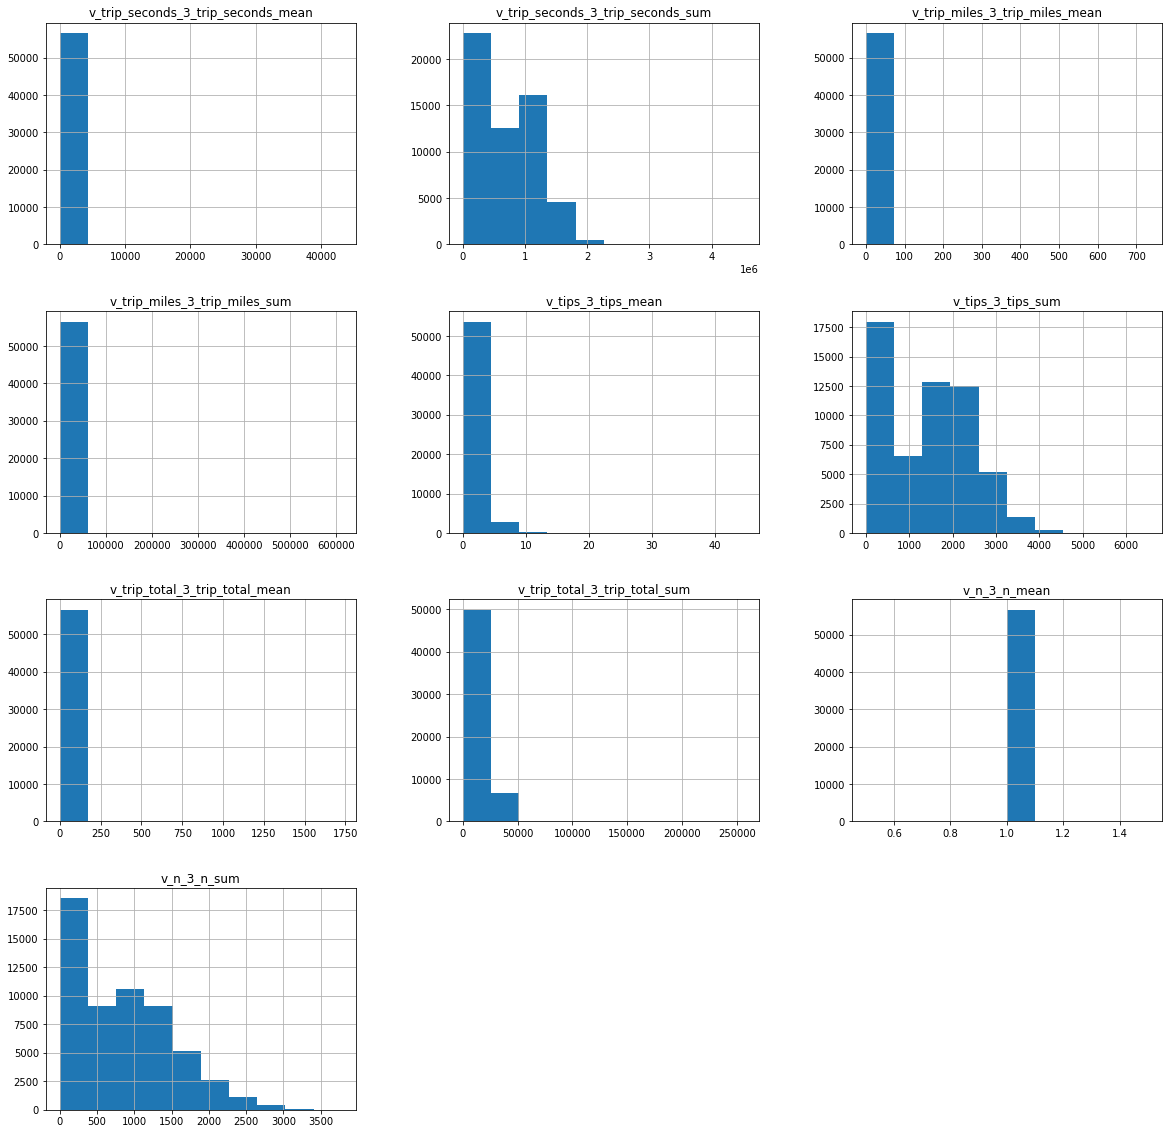

In [97]:
tad[varc].hist(figsize=(20,20))

In [102]:
ol = tad[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist()

In [104]:
for v,li,ls in ol:
    tad['ol_%s'%v] = ((tad[v]<li)|(tad[v]>ls)).astype(int)

In [106]:

varo = [v for v in tad.columns if v[:2]=='ol']

In [107]:
varo

['ol_v_trip_seconds_3_trip_seconds_mean',
 'ol_v_trip_seconds_3_trip_seconds_sum',
 'ol_v_trip_miles_3_trip_miles_mean',
 'ol_v_trip_miles_3_trip_miles_sum',
 'ol_v_tips_3_tips_mean',
 'ol_v_tips_3_tips_sum',
 'ol_v_trip_total_3_trip_total_mean',
 'ol_v_trip_total_3_trip_total_sum',
 'ol_v_n_3_n_mean',
 'ol_v_n_3_n_sum']

In [108]:
tad['ext'] = tad[varo].max(axis=1)

In [110]:
tad.drop(varo,axis=1,inplace=True)

In [111]:
tad.head()

,taxi_id,v_trip_seconds_3_trip_seconds_mean,v_trip_seconds_3_trip_seconds_sum,ancla,v_trip_miles_3_trip_miles_mean,v_trip_miles_3_trip_miles_sum,v_tips_3_tips_mean,v_tips_3_tips_sum,v_trip_total_3_trip_total_mean,v_trip_total_3_trip_total_sum,v_n_3_n_mean,v_n_3_n_sum,y,ext
0,0.0,741.291946,883620.0,3,4.210403,5018.8,1.669874,1990.49,16.470470,19632.80,1,1192,0,0
1,3.0,684.223602,110160.0,3,0.185714,29.9,1.843851,296.86,15.831739,2548.91,1,161,1,0
2,4.0,631.743772,1065120.0,3,2.878351,4852.9,1.224680,2064.81,12.569698,21192.51,1,1686,0,0
3,5.0,1067.194030,715020.0,3,5.715522,3829.4,1.985672,1330.40,37.203612,24926.42,1,670,0,0
4,6.0,666.156275,844020.0,3,0.000000,0.0,1.390908,1762.28,14.088129,17849.66,1,1267,0,0


In [113]:
tad = tad.loc[tad.ext==0].reset_index(drop=True).drop('ext',axis=1)

In [115]:
tad.head()

,taxi_id,v_trip_seconds_3_trip_seconds_mean,v_trip_seconds_3_trip_seconds_sum,ancla,v_trip_miles_3_trip_miles_mean,v_trip_miles_3_trip_miles_sum,v_tips_3_tips_mean,v_tips_3_tips_sum,v_trip_total_3_trip_total_mean,v_trip_total_3_trip_total_sum,v_n_3_n_mean,v_n_3_n_sum,y
0,0.0,741.291946,883620.0,3,4.210403,5018.8,1.669874,1990.49,16.470470,19632.80,1,1192,0
1,3.0,684.223602,110160.0,3,0.185714,29.9,1.843851,296.86,15.831739,2548.91,1,161,1
2,4.0,631.743772,1065120.0,3,2.878351,4852.9,1.224680,2064.81,12.569698,21192.51,1,1686,0
3,5.0,1067.194030,715020.0,3,5.715522,3829.4,1.985672,1330.40,37.203612,24926.42,1,670,0
4,6.0,666.156275,844020.0,3,0.000000,0.0,1.390908,1762.28,14.088129,17849.66,1,1267,0


array([[<AxesSubplot:title={'center':'v_trip_seconds_3_trip_seconds_mean'}>,
        <AxesSubplot:title={'center':'v_trip_seconds_3_trip_seconds_sum'}>,
        <AxesSubplot:title={'center':'v_trip_miles_3_trip_miles_mean'}>],
       [<AxesSubplot:title={'center':'v_trip_miles_3_trip_miles_sum'}>,
        <AxesSubplot:title={'center':'v_tips_3_tips_mean'}>,
        <AxesSubplot:title={'center':'v_tips_3_tips_sum'}>],
       [<AxesSubplot:title={'center':'v_trip_total_3_trip_total_mean'}>,
        <AxesSubplot:title={'center':'v_trip_total_3_trip_total_sum'}>,
        <AxesSubplot:title={'center':'v_n_3_n_mean'}>],
       [<AxesSubplot:title={'center':'v_n_3_n_sum'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

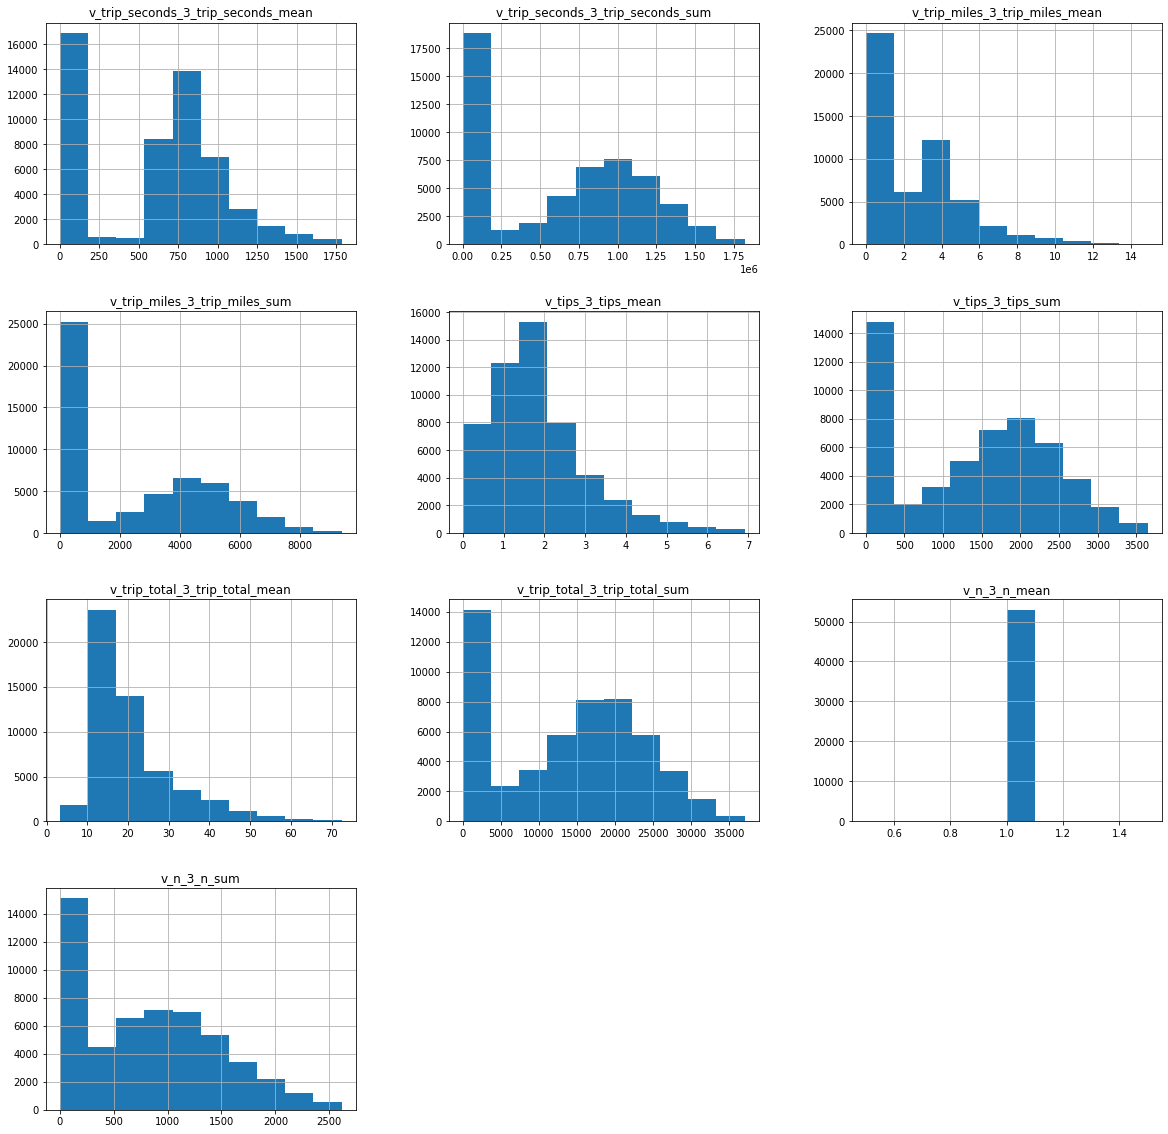

In [116]:
tad[varc].hist(figsize=(20,20))

### Unarias

In [128]:
unarias = [v for v,n in [(v,tad[v].unique().shape[0]) for v in varc] if n ==1 ]
varc = [v for v in varc if v not in unarias]

In [130]:
varc,unarias

(['v_trip_seconds_3_trip_seconds_mean',
  'v_trip_seconds_3_trip_seconds_sum',
  'v_trip_miles_3_trip_miles_mean',
  'v_trip_miles_3_trip_miles_sum',
  'v_tips_3_tips_mean',
  'v_tips_3_tips_sum',
  'v_trip_total_3_trip_total_mean',
  'v_trip_total_3_trip_total_sum',
  'v_n_3_n_sum'],
 [])

### Correlación lineal

In [131]:
tad[varc].corr()

,v_trip_seconds_3_trip_seconds_mean,v_trip_seconds_3_trip_seconds_sum,v_trip_miles_3_trip_miles_mean,v_trip_miles_3_trip_miles_sum,v_tips_3_tips_mean,v_tips_3_tips_sum,v_trip_total_3_trip_total_mean,v_trip_total_3_trip_total_sum,v_n_3_n_sum
v_trip_seconds_3_trip_seconds_mean,1.000000,0.723875,0.728553,0.627561,0.103414,0.568804,-0.195191,0.661547,0.502365
v_trip_seconds_3_trip_seconds_sum,0.723875,1.000000,0.434337,0.738589,-0.122446,0.787560,-0.402090,0.931843,0.921465
v_trip_miles_3_trip_miles_mean,0.728553,0.434337,1.000000,0.770003,0.180988,0.394680,-0.034138,0.434157,0.252710
v_trip_miles_3_trip_miles_sum,0.627561,0.738589,0.770003,1.000000,-0.006832,0.624587,-0.236128,0.719157,0.639459
v_tips_3_tips_mean,0.103414,-0.122446,0.180988,-0.006832,1.000000,0.255924,0.328740,0.069162,-0.142760
v_tips_3_tips_sum,0.568804,0.787560,0.394680,0.624587,0.255924,1.000000,-0.284671,0.926966,0.804536
v_trip_total_3_trip_total_mean,-0.195191,-0.402090,-0.034138,-0.236128,0.328740,-0.284671,1.000000,-0.344018,-0.500090
v_trip_total_3_trip_total_sum,0.661547,0.931843,0.434157,0.719157,0.069162,0.926966,-0.344018,1.000000,0.916581
v_n_3_n_sum,0.502365,0.921465,0.252710,0.639459,-0.142760,0.804536,-0.500090,0.916581,1.000000


In [132]:
varc.remove('v_trip_seconds_3_trip_seconds_sum')
varc.remove('v_n_3_n_sum')
varc.remove('v_tips_3_tips_sum')

In [135]:
tad[varc].corr()

,v_trip_seconds_3_trip_seconds_mean,v_trip_miles_3_trip_miles_mean,v_trip_miles_3_trip_miles_sum,v_tips_3_tips_mean,v_trip_total_3_trip_total_mean,v_trip_total_3_trip_total_sum
v_trip_seconds_3_trip_seconds_mean,1.000000,0.728553,0.627561,0.103414,-0.195191,0.661547
v_trip_miles_3_trip_miles_mean,0.728553,1.000000,0.770003,0.180988,-0.034138,0.434157
v_trip_miles_3_trip_miles_sum,0.627561,0.770003,1.000000,-0.006832,-0.236128,0.719157
v_tips_3_tips_mean,0.103414,0.180988,-0.006832,1.000000,0.328740,0.069162
v_trip_total_3_trip_total_mean,-0.195191,-0.034138,-0.236128,0.328740,1.000000,-0.344018
v_trip_total_3_trip_total_sum,0.661547,0.434157,0.719157,0.069162,-0.344018,1.000000


## Modelos

### Partición

In [143]:
X = tad[varc].copy()
y = tad[tgt]
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

### Perceptrón

In [147]:
modelo = Perceptron()

In [151]:
hyper = dict(penalty = ['l2','l1','elasticnet'],
             fit_intercept=[True,False],
             max_iter=range(1000,21000,1000),
             eta0 = np.arange(0.1,1,0.1))

In [155]:
grid = GridSearchCV(estimator=modelo,
                    error_score='roc_auc',
                    param_grid=hyper,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

In [157]:
print(grid.best_score_)

print(grid.best_params_)

0.8571235578611764

In [159]:
modelo = grid.best_estimator_
modelo.fit(Xt,yt)

In [163]:
print(accuracy_score(y_true=yt,y_pred=modelo.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modelo.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modelo.predict(Xv)))

0.8485855556456189
0.8488936518943453


### Pasivo-Agresivo

In [166]:
modelo = PassiveAggressiveClassifier()

In [168]:
hyper = dict(C = np.arange(0.1,2,0.1),
             fit_intercept=[True,False],
             max_iter=range(1000,21000,1000))

In [169]:
grid = GridSearchCV(estimator=modelo,
                    error_score='roc_auc',
                    param_grid=hyper,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

Fitting 3 folds for each of 760 candidates, totalling 2280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1468 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2280 out of 2280 | elapsed:   15.5s finished


GridSearchCV(cv=3, error_score='roc_auc',
             estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'fit_intercept': [True, False],
                         'max_iter': range(1000, 21000, 1000)},
             verbose=True)

In [170]:
print(grid.best_score_)

print(grid.best_params_)

0.8601226662343628
{'C': 0.5, 'fit_intercept': False, 'max_iter': 17000}


In [171]:
modelo = grid.best_estimator_
modelo.fit(Xt,yt)

PassiveAggressiveClassifier(C=0.5, fit_intercept=False, max_iter=17000)

In [172]:
print(accuracy_score(y_true=yt,y_pred=modelo.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modelo.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modelo.predict(Xv)))

0.859447191375537
0.8595473743932421
[[28979  1317]
 [ 3885  2830]]
[[12464   584]
 [ 1644  1171]]


### Máquina Vector Soporte

In [203]:
X = tad.sample(5000)
y = X[tgt]
X = X[varc].copy()
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

In [204]:
modelo = SVC()

In [205]:
hyper = dict(C = np.arange(0.1,2,0.1),
             kernel=['linear', 'poly', 'rbf', 'sigmoid'],
             degree=range(2,6),
             gamma = ['scale', 'auto'],
             probability = [True]
            )

In [206]:
sc = MinMaxScaler()
sc.fit(X)

MinMaxScaler()

In [207]:
X.describe()

,v_trip_seconds_3_trip_seconds_mean,v_trip_miles_3_trip_miles_mean,v_trip_miles_3_trip_miles_sum,v_tips_3_tips_mean,v_trip_total_3_trip_total_mean,v_trip_total_3_trip_total_sum
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,592.846237,2.485071,2427.357074,1.826742,21.121209,13556.700246
std,446.812983,2.732035,2500.899250,1.232560,10.639265,9690.147174
min,0.000000,0.000000,0.000000,0.000000,3.250000,3.250000
25%,3.718651,0.000000,0.000000,1.134112,14.236732,2231.675000
50%,715.449204,2.537763,1920.350000,1.638150,17.648622,15189.665000
75%,888.407943,4.064359,4660.700000,2.415220,24.251250,21018.542500
max,1783.846154,14.532078,9397.390000,6.744268,72.025000,36527.310000


In [208]:
Xt = pd.DataFrame(sc.transform(Xt),columns=varc)
Xv = pd.DataFrame(sc.transform(Xv),columns=varc)

In [209]:
grid = RandomizedSearchCV(estimator=modelo,
                    error_score='roc_auc',
                    param_distributions=hyper,
                    n_iter=200,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished


RandomizedSearchCV(cv=3, error_score='roc_auc', estimator=SVC(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                                        'degree': range(2, 6),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'probability': [True]},
                   verbose=True)

In [210]:
print(grid.best_score_)
print(grid.best_params_)

0.8617140998185767
{'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 0.5}


In [211]:
modelo = grid.best_estimator_

modelo.fit(Xt,yt)

SVC(C=0.5, probability=True)

In [212]:
print(accuracy_score(y_true=yt,y_pred=modelo.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modelo.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modelo.predict(Xv)))

print(roc_auc_score(y_true=yt,y_score=modelo.predict_proba(Xt)[:,1]))
print(roc_auc_score(y_true=yv,y_score=modelo.predict_proba(Xv)[:,1]))

0.8682857142857143
0.8506666666666667
[[2751  135]
 [ 326  288]]
[[1139   54]
 [ 170  137]]
0.8338135805562515
0.8195076600473447


/home/jose/entornos/ins/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/home/jose/entornos/ins/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

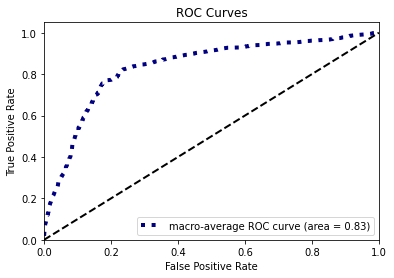

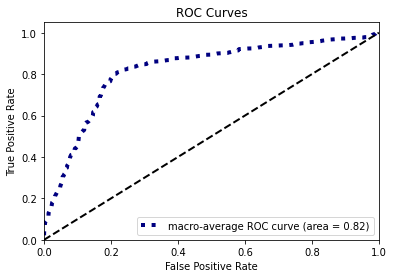

In [214]:
plot_roc_curve(y_true=yt,y_probas=modelo.predict_proba(Xt),curves='macro')
plot_roc_curve(y_true=yv,y_probas=modelo.predict_proba(Xv),curves='macro')

## Uso del Modelo

In [259]:
Xv['p'] = modelo.predict_proba(Xv[varc])[:,1]

In [260]:
Xv['p'] = pd.cut(Xv['p'],bins=np.arange(0,1.2,0.2),include_lowest=True).astype(str)

<AxesSubplot:>

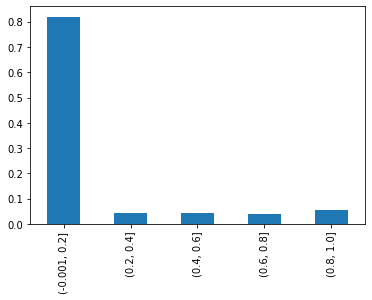

In [261]:
Xv['p'].value_counts(1).sort_index().plot(kind='bar')

In [262]:
Xv.head()

,v_trip_seconds_3_trip_seconds_mean,v_trip_miles_3_trip_miles_mean,v_trip_miles_3_trip_miles_sum,v_tips_3_tips_mean,v_trip_total_3_trip_total_mean,v_trip_total_3_trip_total_sum,p,n,y
0,0.000234,0.000000,0.000000,0.349736,0.161350,0.338902,"(-0.001, 0.2]",1,NaN
1,0.573501,0.020905,0.005108,0.356712,0.281335,0.097672,"(-0.001, 0.2]",1,NaN
2,0.505434,0.280521,0.483249,0.030902,0.176772,0.469846,"(-0.001, 0.2]",1,NaN
3,0.000000,0.000000,0.000000,0.556028,0.488913,0.010007,"(-0.001, 0.2]",1,NaN
4,0.541241,0.299092,0.207206,0.227554,0.245242,0.246658,"(-0.001, 0.2]",1,NaN


In [263]:
Xv['n'] = 1

In [264]:
Xv['y'] = yv.reset_index(drop=True)

In [265]:
Xv[['p','n']].groupby('p').sum().to_clipboard()

In [267]:
Xv[['p','y']].groupby('p').sum().to_clipboard()

In [257]:
Xv.shape

(1500, 9)

In [256]:
Xv.pivot_table(index='p',columns='y',values='n',aggfunc='count')

y,0.0,1.0
p,,
"(-0.001, 0.2]",29.0,2.0
"(0.4, 0.6]",3.0,NaN
"(0.6, 0.8]",2.0,NaN
"(0.8, 1.0]",3.0,1.0


In [241]:
tad['v_trip_total_3_trip_total_sum'].describe()

count    52874.000000
mean     13603.632474
std       9731.086884
min          3.250000
25%       2232.075000
50%      15238.945000
75%      21111.567500
max      37034.340000
Name: v_trip_total_3_trip_total_sum, dtype: float64

In [258]:
yv.shape

(1500,)